### Run Incidents Model

- Here we present a demo of running inference with our model, from a checkpoint.
- To train a model for yourself, please see the `README.md` with instructions for using `run_model.py`.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pprint
import json
from tqdm import tqdm
import cv2
import torch
import matplotlib.pyplot as plt
%matplotlib inline

from architectures import (
    FilenameDataset,
    get_incidents_model,
    update_incidents_model_with_checkpoint,
    update_incidents_model_to_eval_mode,
    get_predictions_from_model
)
from parser import get_parser, get_postprocessed_args

In [3]:
# data
IMAGES_PATH = "/data/vision/torralba/humanitarian/datasets/images_raw/"
DATASET_FILENAME = "data/eccv_val.json"

# model
CONFIG_FILENAME = "configs/eccv_final_model"
CHECKPOINT_PATH_FOLDER = "pretrained_weights/"

In [4]:
with open(DATASET_FILENAME, "r") as fp:
    dataset = json.load(fp)

In [5]:
image_filenames = [os.path.join(IMAGES_PATH, image_name) for image_name in list(dataset.keys())[:4]]

In [6]:
# you can replace the filenames with your own
image_filenames

['/data/vision/torralba/humanitarian/datasets/images_raw/ship_incident_in_junkyard/00078.jpg',
 '/data/vision/torralba/humanitarian/datasets/images_raw/van_accident_in_medina/0a08f1a0a1.jpg',
 '/data/vision/torralba/humanitarian/datasets/images_raw/landslide_in_port/00317.jpg',
 '/data/vision/torralba/humanitarian/datasets/images_raw/track_collision_in_forest/920d91f8aa.jpg']

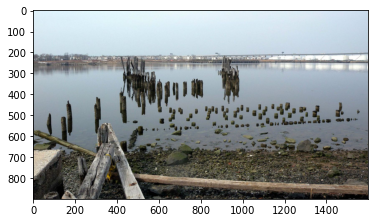

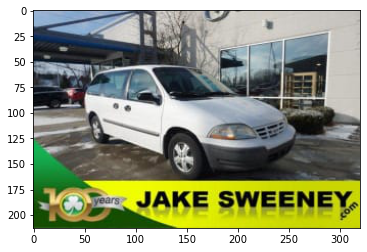

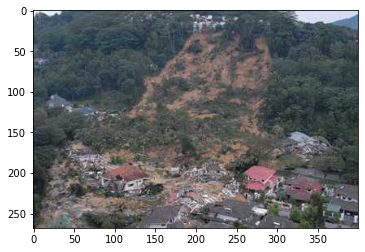

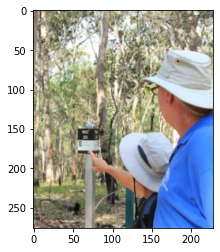

In [7]:
for image_filename in image_filenames:
    img = cv2.imread(image_filename)[:,:,::-1].copy() 
    plt.imshow(img)
    plt.show()

In [8]:
# Load model from checkpoint.
parser = get_parser()
args = parser.parse_args(args="--config={} --checkpoint_path={} --mode=test --num_gpus=1".format(CONFIG_FILENAME, CHECKPOINT_PATH_FOLDER))
args = get_postprocessed_args(args)

incidents_model = get_incidents_model(args)
update_incidents_model_with_checkpoint(incidents_model, args)
update_incidents_model_to_eval_mode(incidents_model)

loading places weights for pretraining
Let's use 1 GPUs!
eccv_final_model
Loaded checkpoint 'pretrained_weights/eccv_final_model_trunk.pth.tar' (epoch 15).
Loaded checkpoint 'pretrained_weights/eccv_final_model_place.pth.tar' (epoch 15).
Loaded checkpoint 'pretrained_weights/eccv_final_model_incident.pth.tar' (epoch 15).
Switching to eval mode.


In [9]:
from utils import get_index_to_incident_mapping, get_index_to_place_mapping

In [10]:
# Set up the data loader for quickly loading images to run inference with.
print("num images: {}".format(len(image_filenames)))
targets = [image_filenames[i] for i in range(len(image_filenames))]
dataset = FilenameDataset(image_filenames, targets)
loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=1,
    shuffle=False,
    num_workers=4
)

inference_dict = {}
for idx, (batch_input, image_paths) in tqdm(enumerate(loader)):
    # run the model, get the output, set the inference_dict
    output = get_predictions_from_model(
        args,
        incidents_model,
        batch_input,
        image_paths,
        get_index_to_incident_mapping(),
        get_index_to_place_mapping(),
        inference_dict,
        topk=5
    )

num images: 4


4it [00:00,  7.44it/s]


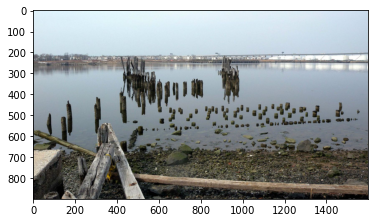

{'incident_probs': array([0.5656243 , 0.1217377 , 0.01642113, 0.01232788, 0.01209307],
      dtype=float32),
 'incidents': ['flooded',
               'fog',
               'dirty contamined',
               'tropical cyclone',
               'oil spill'],
 'place_probs': array([0.25535876, 0.18925062, 0.10614549, 0.06635133, 0.04386293],
      dtype=float32),
 'places': ['lake natural', 'field', 'river', 'farm', 'building outdoor']}


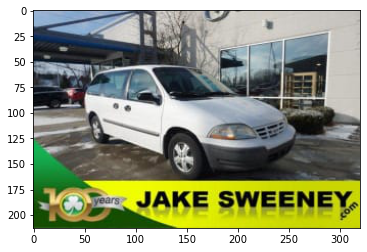

{'incident_probs': array([0.13606068, 0.01503196, 0.00888494, 0.00577288, 0.0044633 ],
      dtype=float32),
 'incidents': ['blocked',
               'mudslide mudflow',
               'car accident',
               'damaged',
               'sinkhole'],
 'place_probs': array([0.7864487 , 0.5420763 , 0.08671698, 0.01091081, 0.00827659],
      dtype=float32),
 'places': ['gas station',
            'parking lot',
            'building outdoor',
            'industrial area',
            'downtown']}


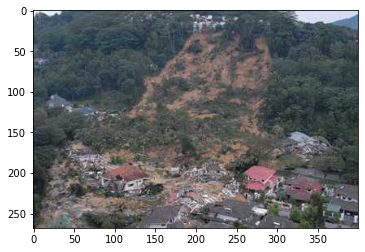

{'incident_probs': array([0.3340528 , 0.05638415, 0.02221016, 0.00521828, 0.00418804],
      dtype=float32),
 'incidents': ['landslide',
               'mudslide mudflow',
               'rockslide rockfall',
               'with smoke',
               'wildfire'],
 'place_probs': array([0.8233393 , 0.08113188, 0.02029859, 0.01943132, 0.01579683],
      dtype=float32),
 'places': ['village',
            'mountain',
            'building outdoor',
            'valley',
            'residential neighborhood']}


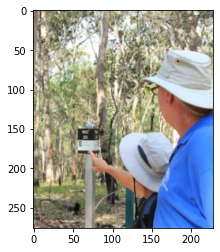

{'incident_probs': array([0.08883425, 0.08775596, 0.07489599, 0.05631863, 0.04826766],
      dtype=float32),
 'incidents': ['car accident',
               'airplane accident',
               'drought',
               'tropical cyclone',
               'dirty contamined'],
 'place_probs': array([0.43148685, 0.14511499, 0.08475208, 0.0560411 , 0.04959034],
      dtype=float32),
 'places': ['forest', 'forest road', 'farm', 'field', 'park']}


In [11]:
for image_filename in inference_dict:
    img = cv2.imread(image_filename)[:,:,::-1].copy() 
    plt.imshow(img)
    plt.show()
    pprint.pprint(inference_dict[image_filename])